In [ ]:
!pip uninstall tensorflow-gpu==2.0.0-alpha0

In [ ]:
!pip install tensorflow==2.4.1
#!pip install tensorflow-gpu==1.14.0

In [ ]:
!pip3 install --upgrade tensorflow 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

**import the data**

In [ ]:
with open('/content/unprocessedquestion.txt','r') as f:
  data = f.read()

**Preprocessing Dataset**
**1. Data transformation**

In [ ]:
uncleaned_data_list = data.split('\n')
len(uncleaned_data_list)
#uncleaned_data_list = uncleaned_data_list[:38695]
#len(uncleaned_data_list)
Aquestion_word = []
logicF_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  #Aquestion_word.append(word.split('\t')[:-1][0])
  #logicF_word.append(word.split('\t')[:-1][1])
  Aquestion_word.append(word.split('\t')[0])
  logicF_word.append(word.split('\t')[1])
language_data = pd.DataFrame(columns=['question','logicform'])
language_data['question'] = Aquestion_word
language_data['logicform'] = logicF_word
language_data.to_csv('language_data.csv', index=False)

In [ ]:
language_data.head()

,question,logicform
0,አዳማ ከነማ ስፖርት ክለብ በ1932 6ኛ ነው የወጣው,"answer ( ? , ደረጃ_1932 ( አዳማ_ከነማ_ክለብ , 6ኛ ) )"
1,ደደቢት እግርኳስ ክለብ ስፖርት ክለብ በ1960 7ኛ ነው የወጣው,"answer ( ? , ደረጃ_1960 ( ደደቢት_እግርኳስ_ክለብ_ክለብ , 7..."
2,የሲዳማ ምስራቃዊ ስፖርት ክለብ ፕሪሚየር ሊግ ይሳተፋል,"answer ( ? , ሊግ ( ሲዳማ_ምስራቃዊ_ክለብ , ኢትዮጵያ_ፕሪሚየር_..."
3,ከኢትዮጵያ ወንድ እሯጮች በክብደት ትልቁ ማነው,"answer ( A , argmax ( ( ሀገር ( A , ኢትዮጵያ ) , ጾታ..."
4,መከላከያ ስፖርት ክለብ በ1989 3ኛ ነው የወጣው,"answer ( ? , ደረጃ_1989 ( መከላከያ_ክለብ , 3ኛ ) )"


In [ ]:
question_text = language_data['question'].values
logicf_text = language_data['logicform'].values
len(question_text), len(logicf_text)

(15453, 15453)

**2. Data Cleaning**

In [ ]:
#to lower case
question_text_ = [x.lower() for x in question_text]
#logicf_text = [x.lower() for x in logicf_text]
#removing inverted commas
question_text_ = [re.sub("'",'',x) for x in question_text_]
#logicf_text = [re.sub("'",'',x) for x in logicf_text]

def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text

question_text_ = remove_punc(question_text_)
#logicf_text = remove_punc(logicf_text)
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []

for sent in question_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
  
question_text_ = removed_digits_text
# removing the digits from the marathi sentances
#logicf_text = [re.sub("[२३०८१५७९४६]","",x) for x in logicf_text]
#logicf_text = [re.sub("[\u200d]","",x) for x in logicf_text]
# removing the stating and ending whitespaces
question_text_ = [x.strip() for x in question_text_]
#logicf_text = [x.strip() for x in logicf_text]

**Adding ‘start’ and ‘end’ tag to marathi sentence**

In [ ]:
# Putting the start and end words in the logic form
logicf_text_ = ["start " + x + " end" for x in logicf_text]
question_text_=question_text
#marathi_text_ = ["start " + x + " end" for x in marathi_text_]
# manipulated_marathi_text_
logicf_text_[0], question_text_[0]

('start answer ( ? , ደረጃ_1932 ( አዳማ_ከነማ_ክለብ , 6ኛ ) ) end',
 'አዳማ ከነማ ስፖርት ክለብ በ1932 6ኛ ነው የወጣው')

**Data preparation for model building**

In [ ]:
X = question_text_
Y = logicf_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2)
print("size of train example",X_train.size)
print("size of test example",X_test.size)
print("size of test example",X_test[20])

size of train example 12362
size of test example 3091
size of test example የበቀል መንገድ የሚለው ፊልም ላይ አንዷለም ደጀን ተውናለች


Let’s determine the maximum length of our sentences in both English and Marathi:

In [ ]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_english = Max_length(X_train)
max_length_marathi = Max_length(y_train)
#Test data
max_length_english_test = Max_length(X_test)
max_length_marathi_test = Max_length(y_test)
max_length_marathi, max_length_english

(46, 14)

**Tokenization:**
As a neural network requires numerical data to process, it becomes necessary to convert our string input to a numerical list. One way of doing this is to use Tokenizer provided by keras-preprocessing library.

In [ ]:
englishTokenizer = Tokenizer(filters='#', lower=False)
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')

marathiTokenizer = Tokenizer(filters='#', lower=False)
marathiTokenizer.fit_on_texts(y_train)
Mword2index = marathiTokenizer.word_index
vocab_size_target = len(Mword2index) + 1

y_train = marathiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')
y_test = marathiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_marathi, padding='post')
vocab_size_source, vocab_size_target

print(X_train[1])

[402 223   7   1  34  11   4   0   0   0   0   0   0   0]


***To save our preprocessing time*** whenever we reuse it again in future, we will save our important attributes. So, let’s do it first with the help of pickle library.

In [ ]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)
with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Mword2index, marathiTokenizer], f)
X_train = np.array(X_train)
print(X_train.shape)
y_train = np.array(y_train)
print(y_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_test = np.array(y_test)
print(y_test.shape)

(12362, 14)
(12362, 46)
(3091, 14)
(3091, 46)


**Model Building**
Instead of a simple encoder-decoder architecture, we will be using Attention Mechanism as discussed earlier in this blog.
Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. For now, we will be using a third party attention mechanism. This attention is an implementation of ‘***Bahdanau Attention’*** .

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/semantic-parser-RNN')

In [ ]:
from attention import AttentionLayer
#from keras import backend as K 
#K.clear_session()

In [ ]:
latent_dim = 500
# Encoder 
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)
#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
plot_model(model, to_file='train_model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

**Model Training**
We will first define some callbacks so that it would be easy for model visualization and evaluation in future.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

**Let's train our Model:**

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=100, 
                    callbacks=[es],
                    batch_size=10,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

**We can visualize **the loss difference in both training and validation phase as:

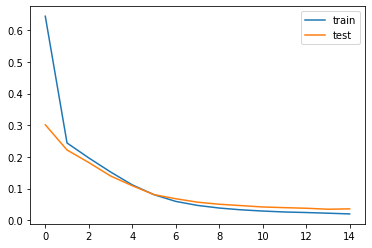

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

**Model Saving and Loading**
Let’s save our trained model with proper weights. Do remember to save the model like I have done as we have to load weights too for the inference model.

In [ ]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


**Load model:**

In [ ]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

**Inference Model**
In machine learning we use inference model to predict our output sequences by considering weights from a pre-trained model. In other terms, it can be said that its a model that deduces properties that are learned in training phase and are now used for predicting new sequences.

In [ ]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(14,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

**Predictions**
Now we have trained the sequence to sequence model and created the inference model using the trained model for making a prediction. Let’s predict some Marathi sentences from the English sentences.

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Mindex2word[sampled_token_index]
        if (sampled_token!='end'):
          decoded_sentence += ' '+sampled_token
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

**Forming a reverse vocabulary:**

In [ ]:
import pickle
pickle_question = open ("NMT_Etokenizer.pkl", "rb")
Qtoken = pickle.load(pickle_question)
Eindex2word=Qtoken[2].index_word

pickle_logic = open ("NMT_Mtokenizer.pkl", "rb")
Ltoken = pickle.load(pickle_logic)
Mindex2word=Ltoken[2].index_word

Mword2index=Ltoken[2].word_index

#Eindex2word = englishTokenizer.index_word
#Mindex2word = marathiTokenizer.index_word

print(Mword2index)

{',': 1, '(': 2, ')': 3, 'A': 4, 'start': 5, 'answer': 6, 'end': 7, 'ፊልም': 8, '?': 9, 'count': 10, 'ተዋናይ': 11, 'B': 12, 'ደራሲ': 13, 'ዘፋኝ': 14, 'C': 15, 'ድርሰት': 16, 'አልበም_ስም': 17, 'ይበልጣል': 18, 'የተለቀቀበት_ጊዜ': 19, 'ሰላም_ተስፋየ': 20, 'መጸሃፍ_አይነት': 21, 'ፕሮዳክሽን': 22, 'ዳይሬክተር': 23, 'ሙዚቃ_ስልት': 24, '2009': 25, 'ፕሮድዩሰር': 26, 'ሃኖስ_ፊልም_ፕሮዳክሽን': 27, 'ፊልም_አይነት': 28, 'ሮማንቲክ': 29, 'እውቀቱ_ስዩም': 30, 'የበቀል_መንገድ': 31, '),': 32, 'ካሳሁን_ፍሰሃ': 33, 'ያልተከፈለ': 34, 'ተጨዋች': 35, 'ስብሐት_ገብረእግዚአብሔር': 36, 'መገኛ_ክልል': 37, 'አርዕስት': 38, 'ጃኖ_ባንድ': 39, 'የታተመባት_ጊዜ': 40, 'ጂጂ': 41, 'ሙዚቃ_መሳሪያ': 42, 'ኦርጋን': 43, 'ትርጉም_መጸሃፍ': 44, 'ያስተሰርያል': 45, 'ማሞ_ውድነህ': 46, 'ኅሊና_ደወል': 47, 'የሞተበት_ጊዜ': 48, 'የተወለደበት_ጊዜ': 49, 'በዓሉ_ግርማ': 50, 'ድንግል_ፍቅር': 51, 'እሯጭ': 52, 'ጋዜጠኛ': 53, 'አሜን_ባሻገር': 54, 'ከፍታ': 55, 'ኦሮማይ': 56, 'አልበም_አታሚ': 57, 'አሳታሚ': 58, 'A)': 59, 'የታተመበተ_ጊዜ': 60, 'አሊ_ቢራ': 61, 'ግጥም_መጸሃፍ': 62, 'አለማየሁ_ገላጋይ': 63, 'እህት': 64, 'ዋና_ከተማ': 65, 'ታምራት_ደስታ': 66, 'መገኛ_ቦታ': 67, 'ፉትቦል_ክለብ': 68, 'ኢትዮጵያ': 69, 'መርካቶ_ሰፈሬ': 70, 'ባለቤት': 71, 'አርቲስት': 72, 'ሬጌ': 73, 'አማራ_ክል

**Some transformation before giving a string to the function:**

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

Call the necessary functions and let’s test our translation model:

In [ ]:
import re
for i in range(1):  
  X_test=['ሰላም ተስፋየ ጨለማ የሚለው ፊልም ላይ ተውኗል']
  pickle_question = open ("NMT_Etokenizer.pkl", "rb")
  Qtoken = pickle.load(pickle_question)
  X_test = Qtoken[2].texts_to_sequences(X_test)
  X_test = pad_sequences(X_test, maxlen = 14, padding='post')

  print("Review:",X_test[0])

  #pickle_off = open ("NMT_data.pkl", "rb")
  #emp = pickle.load(pickle_off)
  #print(emp[2][0])

  #print("Review:",X_test)
  print("Review:",seq2text(X_test[0]))

  #print("Review:",seq2text(emp[2][0]))
  #print(X_test[i].shape)
  #print(emp[3][0])
  #print("Original summary:",seq2summary(emp[3][0]))

  print("Predicted summary:",decode_sequence(X_test[0].reshape(1,14)))
  #print("Predicted summary:",decode_sequence(np.pad(X_test[0], (0, 18), 'constant').reshape(1,32)))

  #print("Predicted summary:",decode_sequence(emp[2][0].reshape(1,14)))
  #print("Predicted summary:",decode_sequence(np.pad(emp[2][0], (0, 18), 'constant').reshape(1,32)))
  print("\n")

# **Evaluating the model using Bleu and hlepor scores **

In [ ]:
!pip install hLepor
!pip install nptyping

In [ ]:
from hlepor import single_hlepor_score
from hlepor import hlepor_score

In [ ]:
#evaluation using Bleu score
import re
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

with open('../input/balancedtest/balancedTestdata','r') as f:
  data = f.read()
testData = data.split('\n')

actual, predicted = list(), list()
reference, hypothesis = list(), list()
chencherry = SmoothingFunction()

sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
cou=0

for word in testData:
    cou=cou+1
    print(cou)
    
    X_test=[word.split('\t')[0]]
    #print(X_test)
    pickle_question = open ("../input/semanticmodel/NMT_Etokenizer.pkl", "rb")
    Qtoken = pickle.load(pickle_question)
    X_test = Qtoken[2].texts_to_sequences(X_test)
    X_test = pad_sequences(X_test, maxlen = 14, padding='post')
    
    #print(word.split('\t')[1])
    #print(decode_sequence(X_test[0].reshape(1,14)))
    
    #print('BLEU-1: %f' % sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(1.0, 0, 0, 0)))
    #print('BLEU-2: %f' % sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(0.5, 0.5, 0, 0)))
    #print('BLEU-3: %f' % sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(0.3, 0.3, 0.3, 0)))
    #print('BLEU-4: %f' % sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(0.25, 0.25, 0.25, 0.25)))
    
    #calculating sum...
    sum1=sum1+(sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(1.0, 0, 0, 0)))
    sum2=sum2+(sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(0.5, 0.5, 0, 0)))
    sum3=sum3+(sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(0.3, 0.3, 0.3, 0)))
    sum4=sum4+(sentence_bleu([word.split('\t')[1].split()], decode_sequence(X_test[0].reshape(1,14)).split(), weights=(0.25, 0.25, 0.25, 0.25)))
    

    #actual logic form
    #actual.append(word.split('\t')[1].split())
    #predicted logic form
    #predicted.append(decode_sequence(X_test[0].reshape(1,14)).split())
    
    #calculating sentence level LEPOR...
    #hLepor_value = single_hlepor_score(word.split('\t')[1], decode_sequence(X_test[0].reshape(1,14)))
    #print(round(hLepor_value, 4))
    
    #reference.append(word.split('\t')[1])  
    #hypothesis.append(decode_sequence(X_test[0].reshape(1,14)))
#print("average scores of sentence level BLEU scores...")
print(sum1/686)
print(sum2/686)
print(sum3/686)
print(sum4/686)
#bleu scores
#print("calculating bleu scores...")    
#print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
#print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
#print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))) 

#calculating LEPOR (Length Penalty, Precision, n-gram Position difference Penalty and Recall)...
#hLepor_value = hlepor_score(reference, hypothesis)
#round(hLepor_value, 4)